# MNIST Multilayer Perceptron

## Code setup

In [1]:
# Suppressing warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# Utility imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path
import gc
import pickle

# Source imports
from plotting import training_validation_plotter, accuracy_curves_plotter
from weight_alterations import cannot_electroform_weigths
from mlp_generator import one_layer, two_layers, three_layers, four_layers
from mlp_trainer import dataset_creation, train_MLP

In [3]:
# Importing LaTeX font for plots
os.system('wget -O cmunrm.ttf https://github.com/nicogig/ComputerModern/raw/main/cmunrm.ttf > /dev/null 2>&1')

#!wget -O cmunrm.ttf https://github.com/nicogig/ComputerModern/raw/main/cmunrm.ttf

fpath = Path('cmunrm.ttf')
font = fm.FontProperties(fname='cmunrm.ttf', size=18)

In [4]:
# The statements below are employed to control the mode in which the Jupyter
# notebook operates.

# Legal values: [1, 2, 3, 4]
number_of_hidden_layers = 1

# Legal values: ["compute", "load_from_file"]
opmode = "compute"

## Neural network setup and training

In [5]:
# Create dataset and results lists
MNIST_dataset = dataset_creation()
weights_list = []
histories_list = []

# Helper values
generator_functions = {1: one_layer, 2:two_layers, 3:three_layers, 4:four_layers}
number_of_ANNs = 30

In [6]:
# Model definition and training, repeated 30 times to average out stochastic variancies
for model_number in range(0, number_of_ANNs):

    MNIST_MLP = generator_functions[number_of_hidden_layers]()
    MLP_weights, MLP_history, *_ = train_MLP(MNIST_dataset, MNIST_MLP, epochs=10, batch_size=100)
    weights_list.append(MLP_weights)
    histories_list.append(MLP_history)
    
    if (model_number+1) % 5 == 0 and model_number != 0:
        print("Model #{} finished training.".format(model_number+1))
    
    gc.collect()

Model #5 finished training.
Model #10 finished training.
Model #15 finished training.
Model #20 finished training.
Model #25 finished training.
Model #30 finished training.


## Performance evolution during training

In [7]:
# Plotting training and validation accuracy by averaging over all the models trained in the previous step

epochs = range(1, len(histories_list[0].history["accuracy"]) + 1)
accuracy_values = np.zeros(len(histories_list[0].history["accuracy"]))
validation_accuracy_values = np.zeros(len(histories_list[0].history["accuracy"]))

for MLP_history in histories_list:

    history_dict = MLP_history.history
    accuracy_values += np.array(history_dict["accuracy"])
    validation_accuracy_values += np.array(history_dict["val_accuracy"])

accuracy_values /= len(histories_list)
validation_accuracy_values /= len(histories_list)

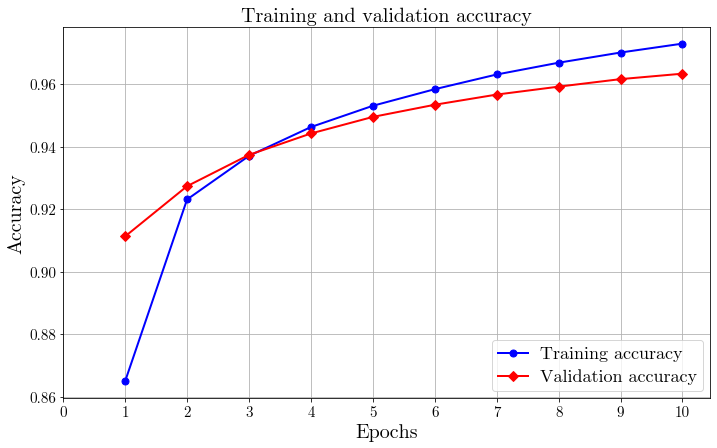

In [8]:
training_validation_plotter(epochs, accuracy_values, validation_accuracy_values, "Accuracy", font)

In [9]:
# Plotting training and validation loss by averaging over all the models trained in the previous step

loss_values = np.zeros(len(histories_list[0].history["accuracy"]))
validation_loss_values = np.zeros(len(histories_list[0].history["accuracy"]))

for MLP_history in histories_list:

    history_dict = MLP_history.history
    loss_values += np.array(history_dict["loss"])
    validation_loss_values += np.array(history_dict["val_loss"])

loss_values /= len(histories_list)
validation_loss_values /= len(histories_list)

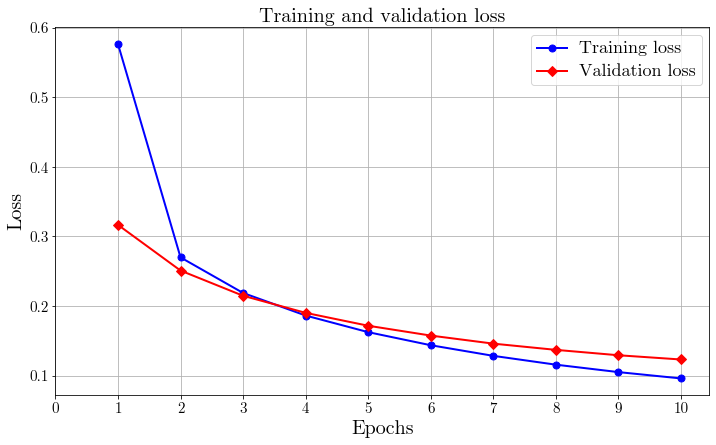

In [10]:
training_validation_plotter(epochs, loss_values, validation_loss_values, "Loss", font)

In [11]:
# Saving data to file
pickle.dump((accuracy_values, validation_accuracy_values, loss_values, validation_loss_values), open("saved_data/training_validation_{}HL.p".format(number_of_hidden_layers), "wb"))

## Type I Fault: Cannot electroform

In [12]:
# Setting variable percentages of the ANN's synaptic weights to zero in order to simulate devices being unable to electroform

percentages = np.arange(0, 1.01, 0.01)
accuracies = np.zeros(len(percentages))

MNIST_MLP = generator_functions[number_of_hidden_layers]()
MNIST_MLP.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

for count, weights in enumerate(weights_list):

    accuracies_list = []

    for percentage in percentages:

        altered_weights = cannot_electroform_weigths(weights, percentage)
        
        # The "set_weights" function sets the ANN's weights to the values specified in the list of arrays "altered_weights"
        MNIST_MLP.set_weights(altered_weights)
        accuracies_list.append(MNIST_MLP.evaluate(MNIST_dataset[1][0], MNIST_dataset[1][1], verbose=0)[1])

    accuracies += np.array(accuracies_list)

    if (count+1) % 5 == 0 and count != 0:
        print("Finished evaluating weight set #{}.".format(count+1))
    
    gc.collect()

accuracies /= len(weights_list)

# Saving accuracies array to file
pickle.dump(accuracies, open("saved_data/accuracies_cannotElectroform_{}HL.p".format(number_of_hidden_layers), "wb"))

Finished evaluating weight set #5.
Finished evaluating weight set #10.
Finished evaluating weight set #15.
Finished evaluating weight set #20.
Finished evaluating weight set #25.
Finished evaluating weight set #30.


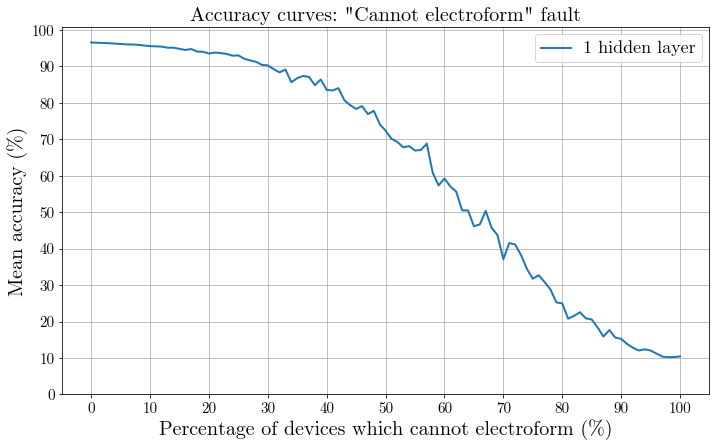

In [13]:
# Opening accuracies array from file
saved_accuracies = pickle.load(open("saved_data/accuracies_cannotElectroform_{}HL.p".format(number_of_hidden_layers), "rb"))

# Plotting accuracy curves
accuracy_label = "{} hidden layers".format(number_of_hidden_layers) if (number_of_hidden_layers != 1) else "1 hidden layer"
accuracy_curves_plotter(percentages, [saved_accuracies], value_type=1, fpath=font, labels=[accuracy_label])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f63981ff-15e3-4a0a-8bcf-dbdeefafcfde' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>